# [08] Keras CNN Testing (normal, benign, malignant)
This notebook is a bit of a warzone, didn't use results from this in the final report, it was pretty much just initially playing around with keras. Code has NOT been curated and probably won't run straight through. Disregard.

Some code here was used from tutorials, they will be cited properly in the final notebooks

In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

import pickle
import random
import math as m
import time
import pandas as pd
import seaborn as sns

In [2]:
%%time
# loading in important variables

# Eigenvectors (just side for testing now)
# with open('train_concat_vectors.npy', 'rb') as f:
#     train_concat_vectors = pickle.load(f) 
# vectors = train_concat_vectors

# Keys
with open('OFFICIAL_keys.pkl', 'rb') as f:
    keys = pickle.load(f)
train_set = keys[:int(0.8*len(keys))]
test_set = keys[int(0.8*len(keys)):int(0.9*len(keys))+1]
validation_set = keys[int(0.9*len(keys))+1:]

# Images
# with open('side_imgs.npy', 'rb') as f:
#     side_imgs = pickle.load(f)
# with open('below_imgs.npy', 'rb') as f:
#     below_imgs = pickle.load(f) 
# with open('concat_imgs.npy', 'rb') as f:
#     concat_imgs = pickle.load(f) 
# scale = (162, 135)
# with open('images.pkl', 'rb') as f:
#     images = pickle.load(f)

# Classifications
with open('classifications.pkl', 'rb') as f:
    classifications = pickle.load(f)
classes = []
for i in range(2575):
    if classifications[2*i] != classifications[2*i+1]:
        print("Classification not equal")
    classes.append(classifications[2*i])
classes = np.array(classes)

# Abnormalities
with open('abnormalities.pkl', 'rb') as f:
    abnormalities = pickle.load(f)
abnorms = []
for i in range(2575):
    if abnormalities[2*i] != abnormalities[2*i+1]:
        print("abnormalities not equal")
    abnorms.append(abnormalities[2*i])
abnorms = np.array(abnorms)

Wall time: 73.8 ms


In [3]:
classes = np.array(classifications)
abnorms = np.array(abnormalities)
print(classes.shape, abnorms.shape)
with open('orientations.pkl', 'rb') as f:
    orientations = pickle.load(f)
orientations = np.array(orientations)
print(orientations.shape)

(5150,) (5150,)
(5150,)


In [4]:
from skimage.transform import resize

def rescale_images(input_images, scale):
    new_list = []
    for image in input_images:
        new_list.append(resize(image, scale))
    return new_list

def np_rescale_images(input_images, scale):
    new_array = np.empty((input_images.shape[0], scale[0], scale[1]))
    for i, image in enumerate(input_images):
        new_array[i] = resize(image, scale)
    return new_array

In [5]:
scale = (725, 605)
# scaled_images = rescale_images(images, scale)

In [6]:
# with open('scaled_images.pkl', 'wb') as f:
#     pickle.dump(scaled_images, f) 

In [ ]:
%%time
with open('scaled_images.pkl', 'rb') as f:
    scaled_images = pickle.load(f)

In [7]:
## Takes flattened images (wxh, n), eigenvectors for the set, and k = new dimensionality
## Returns an array similar to flattened images array but with k instead of n dimensions
def reduce_dimensionality(imgs, vecs, k):
    reduced_dim = np.matmul(vecs[:k], imgs)
    return reduced_dim

## Converts the reduced dimension scan back to original image dimension
def reduced_to_img(reduced, vecs):
    approx = np.matmul(vecs[:reduced.shape[0]].T, reduced)
    return approx

## Combined the above two functions for convenience in creating downscaled images
def reduce_img_dim(imgs, vecs, k):
    return reduced_to_img(reduce_dimensionality(imgs, vecs, k), vecs)

In [8]:
def conv_mat(pred, ground, conv_in_percent=False, print_percentages=False, scale_weights=False):
    cats = pred.max()+1
    conmat = np.zeros((cats,cats))
    for i in range(pred.shape[0]):
        y = pred[i]
        x = ground[i]
        if scale_weights: scale = class_weights[x]*class_weights[y]
        else: scale = 1
        conmat[x, y] += 1*scale
    if print_percentages:
        pred_per = np.empty((cats, 2))
        ground_per = np.empty((cats, 2))
        for i in range(cats):
            pred_per[i] = [i,(np.count_nonzero(pred==i)/pred.shape[0])*100]
            ground_per[i] = [i,(np.count_nonzero(ground==i)/pred.shape[0])*100]
        print()
        print(f"Predicted Percentages: \n{pred_per}\n")
        print(f"Ground Percentages: \n{ground_per}\n")
    if conv_in_percent:
        if scale_weights: size = np.sum(conmat)
        else: size = pred.shape[0]
        conmat = np.round_((conmat / size)*100, 1)
    plt.figure(figsize=(3,3))
    sns.set(font_scale=1) 
    sns.heatmap(conmat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Value")
    plt.ylabel("Actual Value")
    return conmat

In [9]:
## This function will splits the images into three groups side view, bottom view, and a combined concatenated view
## Takes (index, row, col) returns three np arrays in with images in flattened form -
## with shape (image, index) in preparation for PCA
def create_side_bottom_concat(np_imgs, to_print=False, orients=orientations):
    side=[]
    below=[]
    flattened_imgs = np_imgs.reshape(np_imgs.shape[0], np_imgs.shape[1]*np_imgs.shape[2])
    if to_print:
        print(flattened_imgs.shape)
    for i in range(0, flattened_imgs.shape[0]):
        if len(orients[i]) == 2:
            side.append(flattened_imgs[i])
        else:
            below.append(flattened_imgs[i])   
    side = np.array(side)
    below = np.array(below)
    concat = np.concatenate((side, below), 1)
    if to_print:
        print('\nconcatenated images')
        print(f'concat.shape={concat.shape}')
        print('\nside images')
        print(f'side.shape={side.shape}')
        print('\nbelow images')
        print(f'below.shape={below.shape}')
    return side, below, concat

In [10]:
# Set Labels
label_classes = ["D2 Normal", "Benign", "Malignant"]
labels = []

# for i in range(classes.shape[0]):
#     if classes[i] == "D2 Normal":
#         labels.append(0)
#     else:
#         labels.append(1)

# for i in range(abnorms.shape[0]):
#     if abnorms[i] == "calcification"  or abnorms[i] == "both":
#         labels.append(1)
#     else:
#         labels.append(0)

for i in range(classes.shape[0]):
    if classes[i] == "D2 Normal":
        labels.append(0)
    elif classes[i] == "Benign":
        labels.append(1)
    else:
        labels.append(2)

labels = np.array(labels)

In [33]:
dims = 2500
# scans = reduce_dimensionality(concat_imgs.T, vectors, dims).T
# inputs = scans
# reshaped_concat_imgs = concat_imgs.reshape(2575, scale[0]*2, scale[1])
inputs = scaled_images
def set_inputs(new_inputs):
    X_train = new_inputs[train_set.astype(int)]
    X_test = new_inputs[test_set]
    X_validation = new_inputs[validation_set]
    return X_train, X_test, X_validation
X_train, X_test, X_validation = set_inputs(inputs)
y_train = labels[train_set]
y_test = labels[test_set]
y_validation = labels[validation_set]

TypeError: only integer scalar arrays can be converted to a scalar index

In [23]:
# print(concat_imgs.shape)
# reshaped_concat_imgs = concat_imgs.reshape(2575, 162*2, 135)
# print(test_reshape.shape)
# plt.imshow(test_reshape[3], cmap='gray')

In [24]:
import numpy as np
import mnist
from tensorflow import keras

# The first time you run this might be a bit slow, since the
# mnist package has to download and cache the data.
# train_images = mnist.train_images()
# train_labels = mnist.train_labels()

train_images = X_train
train_labels = y_train
test_images = X_test
test_labels = y_test
validation_images = X_validation
validation_labels = y_validation

print(train_images.shape) # (60000, 28, 28)
print(train_labels.shape) # (60000,)
print(test_images.shape) # (60000, 28, 28)
print(test_labels.shape) # (60000,)
print(validation_images.shape) # (60000, 28, 28)
print(validation_labels.shape) # (60000,)

(2060, 2294, 1914)
(2060,)
(258, 2294, 1914)
(258,)


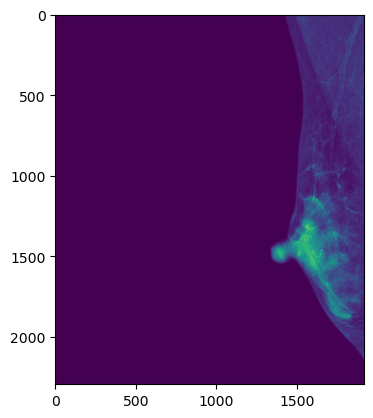

In [27]:
# train_images = mnist.train_images()
# train_labels = mnist.train_labels()
# test_images = mnist.test_images()
# test_labels = mnist.test_labels()

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5
validation_images = (validation_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)
validation_images = np.expand_dims(validation_images, axis=3)

print(train_images.shape) # (60000, 28, 28, 1)
print(test_images.shape)  # (10000, 28, 28, 1)
print(validation_images.shape)  # (10000, 28, 28, 1)

MemoryError: Unable to allocate 67.4 GiB for an array with shape (2060, 2294, 1914) and data type float64

In [243]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

num_filters = 15 # 8
filter_size = 3
pool_size = 2

model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(scale[0], scale[1], 1)),
  MaxPooling2D(pool_size=pool_size),
  Dropout(0),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(3, activation='softmax'),
])
epochs_on_model = 0

In [ ]:
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [245]:
from collections import Counter

counter = Counter(y_train)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}   
print(class_weights)
# class_weights[2] = 0.5
# print(class_weights)

{2: 1.0, 0: 1.7930434782608695, 1: 2.2709251101321586}


In [246]:
from tensorflow.keras.utils import to_categorical
epochs_this = 10
epochs_on_model += epochs_this
model.fit(
  train_images,
  to_categorical(train_labels),
  epochs=epochs_this,
  validation_data=(test_images, to_categorical(test_labels)),
  class_weight=class_weights, 
)

Epoch 1/10
65/65 [==============================] - 11s 158ms/step - loss: 1.8032 - accuracy: 0.3490 - val_loss: 1.1625 - val_accuracy: 0.2326
Epoch 2/10
65/65 [==============================] - 10s 156ms/step - loss: 1.5333 - accuracy: 0.4199 - val_loss: 1.1355 - val_accuracy: 0.2752
Epoch 3/10
65/65 [==============================] - 10s 154ms/step - loss: 1.4229 - accuracy: 0.5165 - val_loss: 1.1272 - val_accuracy: 0.3411
Epoch 4/10
65/65 [==============================] - 10s 155ms/step - loss: 1.3036 - accuracy: 0.5757 - val_loss: 1.1498 - val_accuracy: 0.3760
Epoch 5/10
65/65 [==============================] - 10s 155ms/step - loss: 1.1431 - accuracy: 0.6786 - val_loss: 1.1171 - val_accuracy: 0.4535
Epoch 6/10
65/65 [==============================] - 10s 154ms/step - loss: 0.9800 - accuracy: 0.7403 - val_loss: 1.2755 - val_accuracy: 0.3372
Epoch 7/10
65/65 [==============================] - 10s 155ms/step - loss: 0.8055 - accuracy: 0.8015 - val_loss: 1.3085 - val_accuracy: 0.4109

Epochs so far: 10

65/65 [==============================] - 2s 30ms/step
Train Accuracy = 0.9703883495145631
9/9 [==============================] - 0s 27ms/step
Test Accuracy = 0.39147286821705424
9/9 [==============================] - 0s 27ms/step
Validation Accuracy = 0.4046692607003891

Predicted Percentages: 
[[ 0.         33.85214008]
 [ 1.         19.45525292]
 [ 2.         46.692607  ]]

Ground Percentages: 
[[ 0.         26.07003891]
 [ 1.         23.3463035 ]
 [ 2.         50.58365759]]



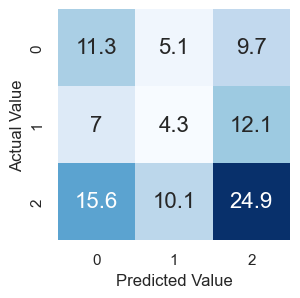

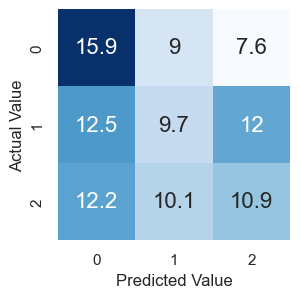

In [247]:
print(f"Epochs so far: {epochs_on_model}\n")

raw_predictions = model.predict(X_train)
predictions = np.argmax(raw_predictions, axis=1)
print(f"Train Accuracy = {accuracy(predictions, y_train)}")

raw_predictions = model.predict(X_test)
predictions = np.argmax(raw_predictions, axis=1)
print(f"Test Accuracy = {accuracy(predictions, y_test)}")

raw_predictions = model.predict(X_validation)
predictions = np.argmax(raw_predictions, axis=1)
print(f"Validation Accuracy = {accuracy(predictions, y_validation)}")

# print(f"Convolution Matrix:\n{conv_mat(predictions, y_validation, True, True)}")
# print(f"Scaled Convolution Matrix:\n{conv_mat(predictions, y_validation, True, False, True)}")
unscaled_conv = conv_mat(predictions, y_validation, True, True)
scaled_conv = conv_mat(predictions, y_validation, True, False, True)

[[0. 0.]
 [0. 0.]
 [0. 0.]]


In [93]:
model.save_weights('3ClassModel_1.h5')

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

num_filters = 8
filter_size = 3
pool_size = 2

# Build the model.
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(2*scale[0], scale[1], 1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(3, activation='softmax'),
])

# Load the model's saved weights.
model.load_weights('3ClassModel_1.h5')

In [110]:
# Predict on the first 5 test images.
raw_predictions = model.predict(X_test)
predictions = np.argmax(raw_predictions, axis=1)
# Print our model's predictions.
print(predictions) # [7, 2, 1, 0, 4]

# Check our predictions against the ground truths.
print(y_test) # [7, 2, 1, 0, 4]

9/9 [==============================] - 0s 19ms/step
[2 0 0 2 1 0 2 0 2 0 1 0 2 0 2 2 1 2 1 2 2 0 2 1 0 2 2 0 2 2 2 1 0 2 2 1 2
 1 2 1 2 1 2 1 1 2 0 2 1 2 1 2 0 2 0 0 1 0 2 0 1 0 2 2 0 2 2 2 2 1 0 2 2 2
 0 2 2 2 0 1 2 0 2 0 2 2 2 2 2 1 0 2 2 2 0 1 0 0 1 2 0 1 0 1 0 2 1 1 1 1 1
 2 0 2 0 0 2 0 0 2 1 1 1 2 2 2 2 0 2 2 2 0 2 2 2 0 2 2 2 0 2 2 0 0 2 2 2 2
 2 2 0 0 1 0 0 0 2 2 2 1 2 0 1 2 0 2 2 2 2 2 1 2 0 1 0 1 2 2 0 0 1 2 2 0 2
 0 2 2 0 1 1 0 2 1 0 2 2 1 2 2 0 1 0 2 1 1 1 1 1 2 2 2 2 2 1 1 2 0 0 2 2 2
 1 0 0 0 0 0 1 2 0 0 2 2 0 1 2 2 2 2 2 2 2 2 1 0 1 0 0 2 2 2 2 2 2 2 2 2]
[1 2 0 1 1 2 1 0 2 2 2 2 0 1 2 0 0 2 0 0 2 2 2 1 2 2 2 2 2 0 0 2 0 0 2 1 2
 0 2 0 0 0 2 2 2 0 2 2 2 2 0 0 2 0 1 2 2 2 0 2 0 0 1 2 2 2 2 2 2 1 2 2 1 2
 2 2 1 0 0 2 2 2 0 0 0 0 0 0 2 0 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 1 0 2 1 2 0
 2 1 2 2 0 0 0 0 2 2 1 2 0 2 0 0 2 2 0 2 0 2 0 2 2 2 2 1 0 2 1 2 2 2 0 2 0
 2 0 2 2 0 2 1 2 2 2 1 0 2 2 2 2 2 1 0 2 1 2 0 2 1 2 2 1 1 2 2 0 0 2 1 1 1
 0 2 2 2 2 0 0 2 0 0 2 0 2 1 1 2 0 0 0 2 2 2 0 2 

In [108]:
def accuracy(pred, ground):
    c = 0
    for i in range(pred.shape[0]):
        if pred[i] == ground[i]:
            c+=1
    return c/pred.shape[0]

In [114]:
accuracy(predictions, y_test)

(258,) (258,)


0.3798449612403101